In [1]:
import datetime
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.decomposition import PCA
import random
import ml_metrics as metrics
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dtype={'is_booking':bool,
       'user_id':np.str_,
        'srch_ci' : np.str_,
        'srch_co' : np.str_,
        'srch_adults_cnt' : np.int32,
        'srch_children_cnt' : np.int32,
        'srch_rm_cnt' : np.int32,
        'srch_destination_id':np.str_,
        'user_location_country' : np.str_,
        'user_location_region' : np.str_,
        'user_location_city' : np.str_,
        'hotel_cluster' : np.str_,
        'orig_destination_distance':np.float64,
        'date_time':np.str_,
        'hotel_market':np.str_}

In [3]:
# load datasets
# test = pd.read_csv("test.csv")
# train = pd.read_csv("train.csv")
destinations = pd.read_csv("destinations.csv")
train = pd.read_csv('train.csv')#,dtype=dtype, usecols=dtype, parse_dates=['date_time'] ,sep=',')

In [4]:
# load datasets
# destinations = pd.read_csv("destinations.csv")
# train = pd.read_csv("train.csv")

In [5]:
# get year and month attributes from date_time
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

In [6]:
train.shape

(37670293, 26)

In [7]:
# fill in missing orig_destination_distance
m=train.orig_destination_distance.mean()
train.orig_destination_distance.fillna(m, inplace=True)

In [8]:
# random 100000 samples
unique_users = train.user_id.unique()
print len(unique_users)

1198786


In [9]:
# pick 100,000 users
selected_user_id = unique_users[:100000]#random.sample(unique_users,10000)
selected_train = train[train.user_id.isin(selected_user_id)]

In [10]:
# train = 2013 | until July 2014; 
# test = After July 2014
train2 = selected_train[((selected_train.year == 2013) | ((selected_train.year == 2014) & (selected_train.month < 8)))]
test2 = selected_train[((selected_train.year == 2014) & (selected_train.month >= 8))]

In [11]:
size = len(selected_train)
print size
print len(train2)
print len(test2)

3095328
1946999
1148329


In [12]:
# only get those whose booking is true
test2 = test2[test2.is_booking == True]

In [13]:
print "train2 - ", len(train2)
print "test2 - ", len(test2)

train2 -  1946999
test2 -  83003


### Generate features from destinations csv

In [14]:
pca = PCA(n_components=3)
dest_small = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = destinations["srch_destination_id"]

### Feature Engineering
- Generate new date features based on date_time, srch_ci, and srch_co.
- Remove non-numeric columns like date_time.
- Add in features from dest_small.
- Replace any missing values with -1.
- Calculate features such as length of stay, check in day, and check out month.

In [15]:
def calc_fast_features(df):
    df.loc[:,'date_time'] = pd.to_datetime(df["date_time"])
    df.loc[:,'srch_ci'] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df.loc[:,'srch_co'] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

In [16]:
df = calc_fast_features(train2)
df.fillna(-1, inplace=True)
predictors = [c for c in df.columns if c not in ["hotel_cluster"]]

/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
t2 = calc_fast_features(test2)
t2.fillna(-1, inplace=True)
testPredictors = [c for c in t2.columns if c not in ["hotel_cluster"]]

### Baseline

In [18]:
most_common_clusters = list(train.hotel_cluster.value_counts().head().index)
predictions = [most_common_clusters for i in range(t2.shape[0])]

In [19]:
most_common_clusters

[91, 41, 48, 64, 65]

In [20]:
target = [[l] for l in t2["hotel_cluster"]]
print "Baseline evaluation: ", metrics.mapk(target, predictions, k=5)

Baseline evaluation:  0.062750743949


### Making predictions

In [21]:
target = [[l] for l in t2["hotel_cluster"]]

In [22]:
def predict_test_file(trained_model, test_data):
    y_predicted = []
    y_pred=clf.predict_proba(test_data[testPredictors])
    
    #take largest 5 probablities' indexes
    y_predicted=y_pred.argsort(axis=1)[:,-5:]
    
    print 'Getting cluster names'
    dict_cluster = {}
    for (k,v) in enumerate(trained_model.classes_):
        dict_cluster[k] = v
        
    print 'Translating to hotel clusters'
    b = []
    for i in np.vstack(y_predicted).flatten():
        b.append(dict_cluster.get(i))
    predict_class=np.array(b).reshape(np.vstack(y_predicted).shape)
#     predict_class=map(lambda x: ' '.join(map(str,x)), predict_class)
    print predict_class
    
#     target = [[l] for l in t2["hotel_cluster"]]
    print "Evaluation: ", metrics.mapk(target,predict_class,k=5)

### Random Forest

In [23]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
clf = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
clf.fit(df[predictors], df['hotel_cluster'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

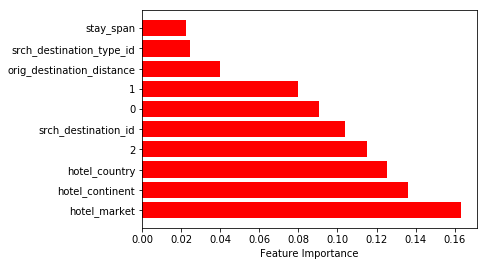

In [24]:
importance = clf.feature_importances_
indices=np.argsort(importance)[::-1][:10]
plt.barh(range(10), importance[indices],color='r')
plt.yticks(range(10),df[predictors].columns[indices])
plt.xlabel('Feature Importance')
plt.show()

In [25]:
# dict_cluster = {}
# for (k,v) in enumerate(clf.classes_):
#     dict_cluster[k] = v

# y_pred=clf.predict_proba(t2[testPredictors])
# #take largest 5 probablities' indexes
# a=y_pred.argsort(axis=1)[:,-5:]

# #take the corresonding cluster of the 5 top indices
# b = []
# for i in a.flatten():
#     b.append(dict_cluster.get(i))
    
# cluster_pred = np.array(b).reshape(a.shape)
# target = [[l] for l in t2["hotel_cluster"]]
# print "Random Forest score: ",metrics.mapk(target,cluster_pred,k=5)

predict_test_file(clf, t2)

Getting cluster names
Translating to hotel clusters
[[88 24 79 45  1]
 [58 36 81 64 46]
 [62 46 82 85 58]
 ..., 
 [50 18 42 48 91]
 [50 41 42 48 91]
 [18 48 41 95 91]]
Evaluation:  0.139442349473


### SGD Classifier

In [39]:
from sklearn import linear_model

clf = linear_model.SGDClassifier(loss='log', n_jobs=-1, alpha=0.0000025, verbose=0)
clf.partial_fit(df[predictors], df['hotel_cluster'], classes=np.arange(100))

SGDClassifier(alpha=2.5e-06, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [40]:
# dict_cluster = {}
# for (k,v) in enumerate(clf.classes_):
#     dict_cluster[k] = v
    
# y_pred=clf.predict_proba(t2[testPredictors])
# #take largest 5 probablities' indexes
# a=y_pred.argsort(axis=1)[:,-5:]

# #take the corresonding cluster of the 5 top indices
# b = []
# for i in a.flatten():
#     b.append(dict_cluster.get(i))
    
# cluster_pred = np.array(b).reshape(a.shape)
# target = [[l] for l in t2["hotel_cluster"]]
# print "Stochastic Gradient Descent (SGD) score: ",metrics.mapk(target,cluster_pred,k=5)

predict_test_file(clf, t2)

Getting cluster names
Translating to hotel clusters
[[45 46 38  9 99]
 [28 27 37  9 99]
 [61 38 98 86 99]
 ..., 
 [27 26 36 99 41]
 [27 26 36 99 41]
 [26 35 99 41 52]]
Evaluation:  0.0169112361401


### Naive Bayes

In [28]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(alpha=1.0)
clf.partial_fit(df[predictors], df['hotel_cluster'], classes=np.arange(100))

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [29]:
# dict_cluster = {}
# for (k,v) in enumerate(clf.classes_):
#     dict_cluster[k] = v

# y_pred=clf.predict_proba(t2[testPredictors])
# #take largest 5 probablities' indexes
# a=y_pred.argsort(axis=1)[:,-5:]

# print "nb_a:", a 

# #take the corresonding cluster of the 5 top indices
# b = []
# for i in a.flatten():
#     b.append(dict_cluster.get(i))

# cluster_pred = np.array(b).reshape(a.shape)
# target = [[l] for l in t2["hotel_cluster"]]
# print "Naive Bayes score: ",metrics.mapk(target,cluster_pred,k=5)
predict_test_file(clf, t2)

Getting cluster names
Translating to hotel clusters
[[88 79 24 45  1]
 [82 59 42 48 91]
 [28 50 42 48 91]
 ..., 
 [79 42 48  1 91]
 [59 28 42 48 91]
 [41 64 46 98 65]]
Evaluation:  0.0628820645037


### Improvements
- Aggregate `hotel_cluster` based on `srch_destination_id`
> find the most popular hotel clusters for each destination to predict that a user who searches for a destination is going to one of the most popular hotel clusters for that destination
- Group training data by `search_destination_id` and `hotel_cluster`
- Iterate each group
> - Assign 1 point to each hotel cluster where `is_booking` is True.
> - Assign .15 points to each hotel cluster where `is_booking` is False.
> - Assign the score to the `srch_destination_id` / `hotel_cluster` combination in a dictionary.

#### Output:
We'll have a dictionary where each key is a `srch_destination_id`. Each value in the dictionary will be another dictionary, containing `hotel_clusters` as keys with scores as values


In [30]:
def make_key(items):
    return "_".join([str(i) for i in items])

match_cols = ["srch_destination_id"]
cluster_cols = match_cols + ['hotel_cluster']
groups = train2.groupby(cluster_cols)
top_clusters = {}
for name, group in groups:
    clicks = len(group.is_booking[group.is_booking == False])
    bookings = len(group.is_booking[group.is_booking == True])
    
    score = bookings + .15 * clicks
    
    clus_name = make_key(name[:len(match_cols)])
    if clus_name not in top_clusters:
        top_clusters[clus_name] = {}
    top_clusters[clus_name][name[-1]] = score

In [31]:
top_clusters

{'11542': {91: 7.25},
 '11543': {27: 1.2},
 '11540': {93: 0.15},
 '11541': {94: 1.15},
 '11547': {6: 0.44999999999999996,
  8: 1.65,
  10: 1.65,
  13: 1.95,
  15: 0.6,
  16: 0.15,
  17: 2.55,
  20: 0.15,
  27: 1.3499999999999999,
  30: 0.3,
  32: 0.3,
  33: 0.8999999999999999,
  35: 0.15,
  39: 0.44999999999999996,
  40: 0.44999999999999996,
  44: 0.44999999999999996,
  47: 2.4,
  48: 1.3499999999999999,
  50: 5.05,
  72: 2.05,
  75: 2.65,
  77: 0.3,
  80: 26.45,
  83: 1.5,
  87: 0.3,
  89: 0.15,
  93: 1.2},
 '11545': {44: 0.15},
 '5988': {42: 0.15},
 '5989': {30: 1.3, 43: 0.15, 53: 0.15, 57: 0.15, 60: 0.15, 62: 0.3},
 '19399': {62: 0.15},
 '19397': {44: 0.3},
 '19396': {39: 1.15},
 '5980': {7: 2.05,
  32: 2.6,
  40: 0.15,
  42: 3.95,
  47: 0.15,
  48: 3.95,
  60: 1.3,
  76: 1.6,
  82: 3.2,
  91: 1.75},
 '19394': {58: 0.3, 78: 0.15},
 '5986': {3: 0.15, 26: 0.3, 33: 0.3, 41: 0.3, 48: 0.3, 91: 0.15, 93: 0.15},
 '5987': {83: 0.44999999999999996},
 '5985': {13: 0.15, 48: 0.15},
 '46139': {

### Find top 5 clusters for each `srch_destination_id`
- Loop through each key in top_clusters.
- Find the top 5 clusters for that key.
- Assign the top 5 clusters to a new dictionary, cluster_dict

In [32]:
import operator

cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top
cluster_dict

{'11542': [91],
 '11543': [27],
 '11540': [93],
 '11541': [94],
 '11547': [80, 50, 75, 17, 47],
 '11545': [44],
 '5988': [42],
 '5989': [30, 62, 43, 53, 57],
 '19399': [62],
 '19397': [44],
 '19396': [39],
 '5980': [42, 48, 82, 32, 7],
 '19394': [58, 78],
 '5986': [33, 41, 48, 26, 3],
 '5987': [83],
 '5985': [48, 13],
 '46139': [89, 44],
 '46137': [53, 3, 44, 86],
 '46136': [3, 60, 53],
 '46133': [32, 42, 14, 39, 47],
 '46130': [63, 58, 30, 3, 78],
 '271': [5],
 '273': [82, 44, 13, 77, 89],
 '16708': [16, 51, 47],
 '19974': [67, 44],
 '16705': [32, 42, 94, 48, 5],
 '279': [64],
 '16702': [3],
 '12019': [34, 63, 73, 65, 78],
 '12018': [91, 10, 11, 48, 42],
 '12015': [42, 16, 91, 32, 48],
 '12014': [91, 16, 42, 55, 47],
 '12017': [91, 42, 7, 72, 2],
 '12016': [42, 91, 77, 16, 68],
 '12011': [50, 91, 94, 32, 68],
 '12010': [42, 91, 28, 94, 32],
 '12013': [32, 7, 82, 28, 6],
 '12012': [28, 91, 47, 42, 16],
 '17250': [62, 44],
 '17251': [36, 8, 67, 78, 61],
 '17252': [82, 78, 48, 29, 61],
 

### Make predictions based on destination
- Iterate each test data
- Extract `srch_destination_id` for the row
- Find top clusters for that `srch_destination_id`
- Append top clusters to preds

#### Output
`preds` - a list of lists containing predictions

In [33]:
preds = []
for index, row in test2.iterrows():
    key = make_key([row[m] for m in match_cols])
    if key in cluster_dict:
        preds.append(cluster_dict[key])
    else:
        preds.append([])

In [34]:
metrics.mapk([[l] for l in test2["hotel_cluster"]], preds, k=5)

0.28740668007983639

### Finding matching users
Finding users in training set that matches in testing set
- Split the training data into groups based on the match columns.
- Loop through the testing data.
- Create an index based on the match columns.
- Get any matches between the testing data and the training data using the groups.

In [35]:
match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 'hotel_market', 'orig_destination_distance']

groups = train2.groupby(match_cols)
    
def generate_exact_matches(row, match_cols):
    index = tuple([row[t] for t in match_cols])
    try:
        group = groups.get_group(index)
    except Exception:
        return []
    clus = list(set(group.hotel_cluster))
    return clus

exact_matches = []
for i in range(test2.shape[0]):
    exact_matches.append(generate_exact_matches(test2.iloc[i], match_cols))

### Combining predictions

In [36]:
def f5(seq, idfun=None): 
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result
    
full_preds = [f5(exact_matches[p] + preds[p] + most_common_clusters)[:5] for p in range(len(preds))]
metrics.mapk([[l] for l in test2["hotel_cluster"]], full_preds, k=5)

0.34581882582557255